In [33]:
import os, import_ipynb
os.chdir('../')
from Utils import *

In [2]:
img_files       = glob('data/1_time_series/gsr/*.csv')
eprime_path     = '/nfs/nfs-davinci/fahad/biobank/data/eprime_files'

data, frames, ys, chunks, corrs, window_ys, window_times, ccs, lags, covs, results, sig_edges\
                = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

for idx, fname in enumerate(tqdm(img_files[:5])):
    subj            = fname.split('/')[-1].split('_')[0].replace('.csv', '')
    data[subj]      = pd.read_csv(fname, index_col=0)
    
    eprime_fname = "%s/%s_25748_2_0.txt" % (eprime_path, subj)
    frames[subj], ys[subj]\
                    = load_frames(eprime_fname, data[subj])
    
    chunks[subj], corrs[subj], window_ys[subj], window_times[subj]\
                    = window_timeseries(data[subj], window=10, ys=ys[subj])
    
    ccs[subj], lags[subj], covs[subj]\
                    = compute_tvfcn_crosscorrs_covs_full(chunks[subj])
    
    rois            = data[subj].columns
    
    results[subj], rels   = get_edge_types(covs[subj], lags[subj], rois, window_ys[subj])

#     counts          = count_edge_types(results, rels)

#     counts_face     = count_edge_types(results.loc[:,np.array(window_ys[subj])=='Face'], rels).replace({0:1})
#     counts_shape    = count_edge_types(results.loc[:,np.array(window_ys[subj])=='Shape'], rels).replace({0:1})

#     pvals           = counts_face.apply(lambda x: chi2_contingency([x.values, counts_shape.loc[x.name].values], lambda_=1)[1], axis=1)
#     pvals.name      = 'pvals'
    
#     labels          = counts[counts>20].fillna(0).apply(lambda x: pd.Series(edge_labels(x)), axis=1)
#     #labels          = counts[counts>(len(window_ys)/5)].fillna(0).apply(lambda x: pd.Series(edge_labels(x)), axis=1)
#     labels.columns  = ['nature', 'arrow']
#     merged          = pd.merge(labels, pvals, left_index=True, right_index=True)
#     sig_edges[subj] = merged[merged['pvals']<(0.001/len(merged))].sort_values('pvals')#[:20]

#     #print(len(sig_edges[subj])/len(merged))

100%|██████████| 5/5 [01:53<00:00, 22.69s/it]


In [33]:
subjs = list(results.keys())[1:]

instabilities = pd.DataFrame([compute_instabilities_from_ts(data[subj], nonoverlapping=False) for subj in subjs])
instabilities2 = pd.concat([results[subj].apply(lambda x: (x>0)!=(np.roll(x, 1)>0), axis=1).mean() for subj in subjs], axis=1).transpose()

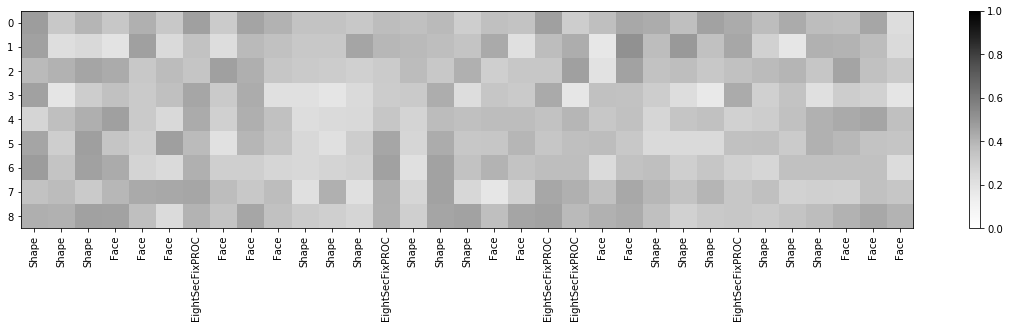

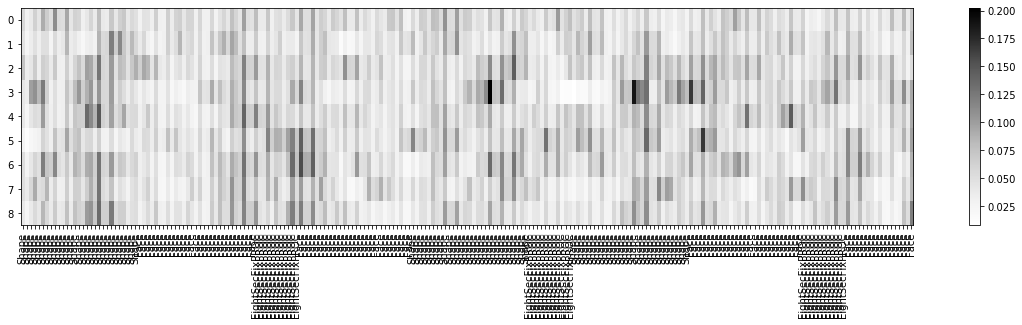

In [37]:
plt.figure(figsize=(20, 4));
plt.imshow(instabilities2, aspect='auto', cmap='Greys', vmin=0, vmax=1);
plt.xticks(range(instabilities2.shape[1]), window_ys[subjs[1]], rotation=90);
plt.colorbar();

plt.figure(figsize=(20, 4));
plt.imshow(instabilities, aspect='auto', cmap='Greys');
plt.xticks(range(instabilities.shape[1]), ys[subjs[1]], rotation=90);
plt.colorbar();

In [136]:
[np.array(results[k].columns).shape[0] for k in results.keys()]

[36, 33, 33, 33, 33, 33, 33, 33, 33, 33]

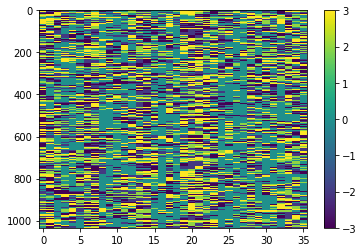

In [128]:
plt.imshow(results['4506964'], aspect='auto');
plt.colorbar();

In [37]:
sig_edges_copy = sig_edges.copy()

In [30]:
ks = list(sig_edges.keys())
common = set(sig_edges[ks[0]].index)
# for k in ks[1:]:
#     common = common.intersection(set(sig_edges[k].index))

In [22]:
rois            = list(data.values())[0].columns

covs_all, lags_all, window_ys_all\
                = pd.concat(covs.values(), axis=1),\
                  pd.concat(lags.values(), axis=1),\
                  np.concatenate(list(window_ys.values()))

results, rels   = get_edge_types(covs_all, lags_all, rois, window_ys_all)
counts          = count_edge_types(results, rels)

counts_face     = count_edge_types(results.loc[:,window_ys_all=='Face'], rels).replace({0:1})
counts_shape    = count_edge_types(results.loc[:,window_ys_all=='Shape'], rels).replace({0:1})

pvals           = counts_face.apply(lambda x: chi2_contingency([x.values, counts_shape.loc[x.name].values], lambda_=1)[1], axis=1)
pvals.name      = 'pvals'

0.0


In [35]:

labels          = counts[counts>10].fillna(0).apply(lambda x: pd.Series(edge_labels(x)), axis=1)
# labels          = counts[counts>(len(window_ys_all)/5)].fillna(0).apply(lambda x: pd.Series(edge_labels(x)), axis=1)
labels.columns  = ['nature', 'arrow']
merged          = pd.merge(labels, pvals, left_index=True, right_index=True)
sig_edges       = merged[merged['pvals']<(0.001/len(merged))].sort_values('pvals')#[:20]

print(len(sig_edges)/len(merged))

0.0


In [53]:
sig_edges = merged[merged['pvals']<0.1].sort_values('pvals')

In [33]:
# sig_edges = pd.read_csv('out/sig_edges.csv', index_col=0)

In [57]:
sig_edges.to_csv('Dynamics/out/sig_edges.csv')

In [26]:
G                 = construct_graph(sig_edges)

In [27]:
coords            = get_mni_coords('data/46_rois.nii.gz', rois)#list(time_series.columns))
pos               = coords[['y', 'z']].transpose().to_dict(orient='list')

## Plotting

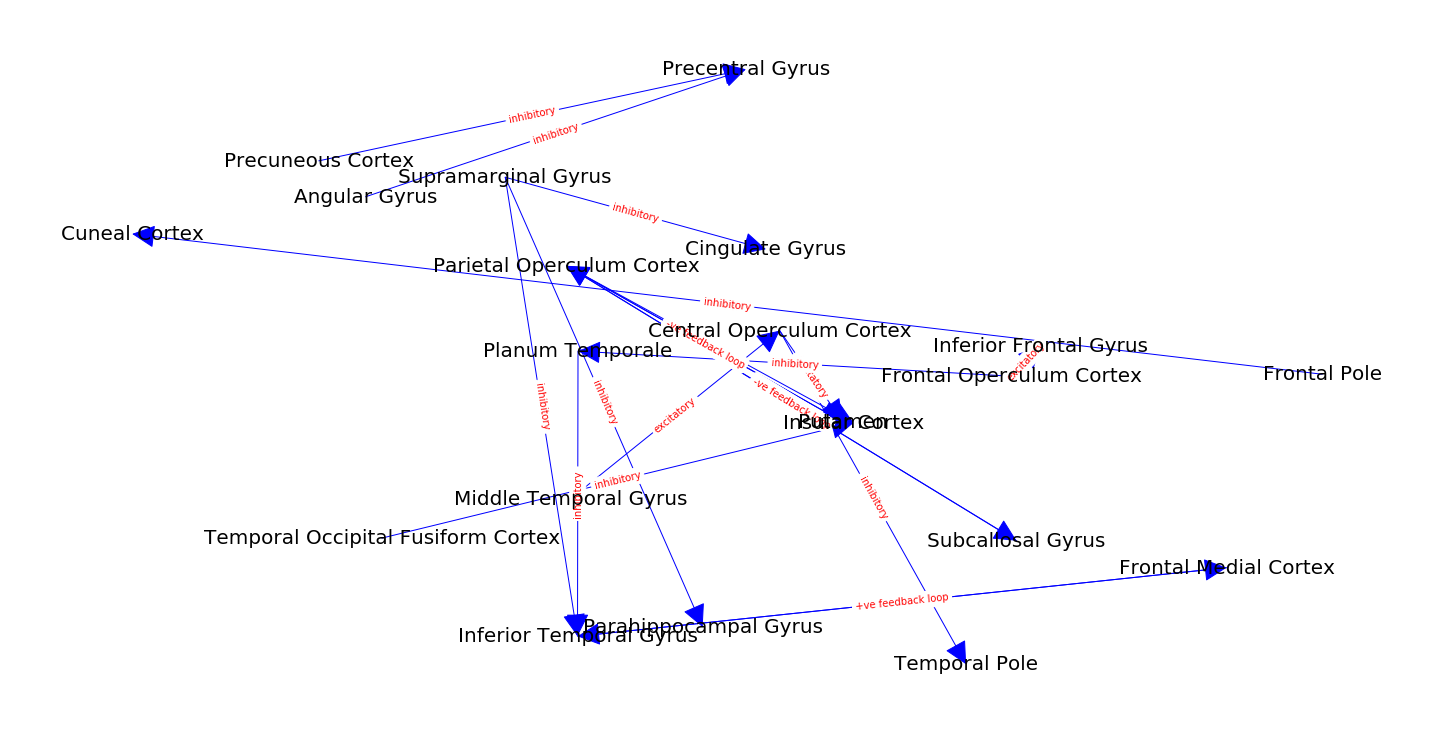

In [28]:
# plot_windowed_timeseries(chunks, ys, time_series.index);
# # plot_windowed_matrices(corrs, window_ys);
# plot_tvfcn(covs, window_ys);
# plot_tvfcn(results, window_ys, cmap='tab20c', vmin=None, vmax=None);
# plot_tvfcn(counts, counts.columns, vmin=None, vmax=None, fontsize=15, xlabel=None, ylabel='Pair of Regions', cmap='Reds', xrotation=0);
draw_graph(G, pos=pos);

In [511]:
from networkx.algorithms import community
# G2 = nx.barbell_graph(5, 1)
communities_generator = community.girvan_newman(G)
comms = [comm for comm in communities_generator]
len(comms)

comps = []
for comp in nx.connected_components(G.to_undirected()):
    comps.append(comp)
    print(len(comp))

In [72]:
counts[counts['x > y']==counts['x << y']].sort_values('x << y')

,-,x > y,x >> y,x < y,x << y
"Putamen, Caudate",56,6,29,3,6
"Superior Temporal Gyrus, Inferior Frontal Gyrus",59,6,12,18,6
"Cerebellum, Supramarginal Gyrus",41,6,32,15,6
"Subcallosal Gyrus, Postcentral Gyrus",62,6,18,9,6
"Planum Polare, Frontal Pole",47,9,12,24,9
...,...,...,...,...,...
"Thalamus, Occipital Fusiform Gyrus",32,21,6,21,21
"Paracingulate Gyrus, Insular Cortex",32,21,6,21,21
"Cerebellum, Middle Temporal Gyrus",29,21,18,12,21
"Central Operculum Cortex, Inferior Frontal Gyrus",32,21,24,3,21


In [21]:
pearsonr(time_series['Amygdala'],\
         time_series['Parahippocampal Gyrus'])

(0.6283559076690878, 7.108853186876975e-38)

-         32
x > y     24
x >> y     6
x < y     15
x << y    24
Name: Frontal Medial Cortex, Middle Frontal Gyrus, dtype: int64


/Users/fahad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


,face,shape
-,43,20
x > y,21,33
x >> y,7,7
x < y,21,13
x << y,7,27


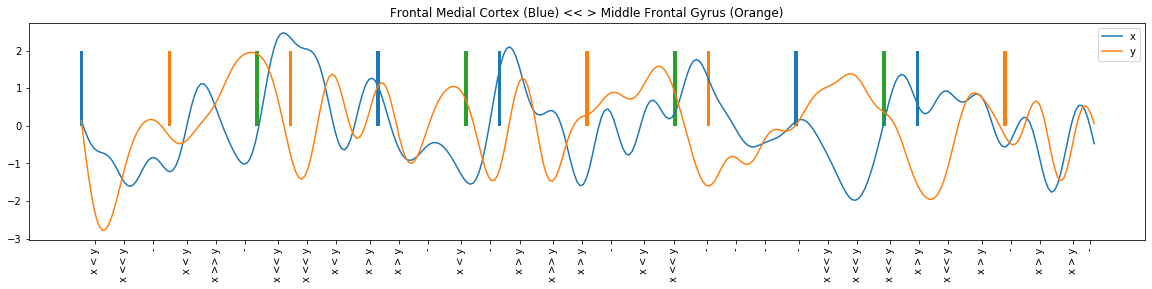

In [75]:
a, b = 'Frontal Medial Cortex', 'Middle Frontal Gyrus'
ab = ', '.join([a, b])
plt.figure(figsize=(20, 4));
plt.plot(time_series[a]);
plt.plot(time_series[b]);
plt.xticks(window_times, results.loc[ab].replace(rel_dict), rotation=90);
plt.legend(['x', 'y']);
plt.title("%s (Blue) << > %s (Orange)" % (a, b));
for proc in frames['Procedure'].unique():
    if proc=='TrialsPROC':
        continue
    filtered = frames[frames['Procedure']==proc]
    plt.bar(filtered['time_sec'], 2)
    
print(counts.loc[ab])
tmp = pd.concat([counts_face.loc[ab],\
           counts_shape.loc[ab]], axis=1)
tmp.columns = ['face', 'shape']
tmp.name = a, b
tmp.replace({1:0})

In [33]:
mean_corrs  = pd.DataFrame()
mean_corrs['face'] = covs.loc[:,np.array(window_ys)=='Face'].mean(axis=1)#corrs2
mean_corrs['shape'] = covs.loc[:,np.array(window_ys)=='Shape'].mean(axis=1)#corrs2

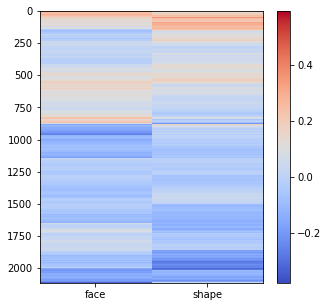

In [34]:
reordered_cols = reorder_columns_by_dist(mean_corrs)
plt.figure(figsize=(5, 5));
plt.imshow(mean_corrs.loc[reordered_cols], aspect='auto', cmap='coolwarm');#, vmin=-1, vmax=1)
plt.colorbar();
plt.xticks([0, 1], mean_corrs.columns);

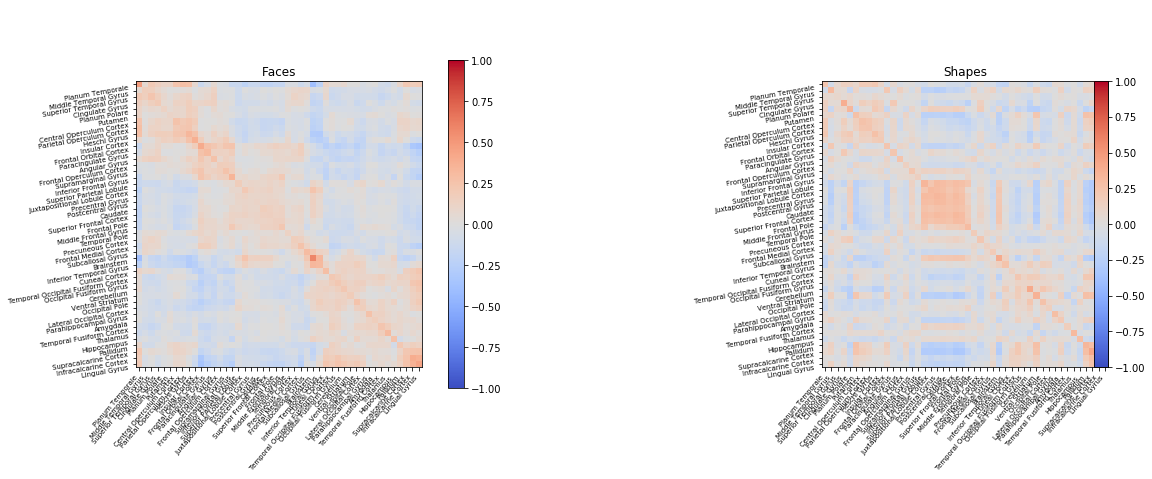

In [35]:
rois        = time_series.columns
face_corr   = pd.DataFrame(mean_corrs['face'].values.reshape(46, 46), index=rois, columns=rois)
shapes_corr = pd.DataFrame(mean_corrs['shape'].values.reshape(46, 46), index=rois, columns=rois)

fig, axs    = plt.subplots(1, 3, figsize=(20, 8))

plotting.plot_matrix(face_corr.values, labels=list(time_series.columns), reorder=True, \
    colorbar=True, axes=axs[0], cmap='coolwarm', vmin=-1, vmax=1);#,vmin=-0.4, vmax=0.4

orderedcols = [label.get_text() for label in axs[0].get_xticklabels()]
plotting.plot_matrix(shapes_corr.loc[orderedcols,orderedcols], labels=orderedcols,\
    colorbar=True, axes=axs[2],cmap='coolwarm', vmin=-1, vmax=1);#vmin=-0.4, vmax=0.4, 

axs[0].set_title('Faces');
axs[1].axis('off');
axs[2].set_title('Shapes');

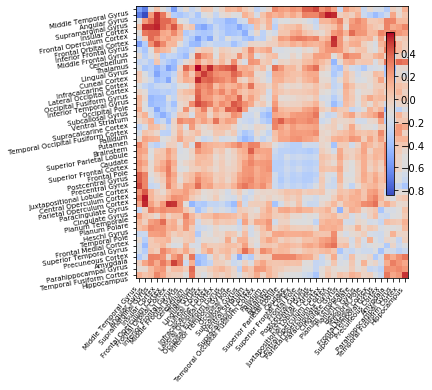

In [11]:
plotting.plot_matrix(face_corr.values-shapes_corr.values, labels=list(time_series.columns), reorder=True, \
    colorbar=True, cmap='coolwarm');#vmin=-0.4, vmax=0.4,


In [27]:
edge_pvals = covs.apply(lambda x: compute_stimulus_pval_edges(x, window_ys, method=ttest_rel, alternative='greater'), axis=1)

edges      = edge_pvals[edge_pvals<0.1]
print(len(edges))
print(len(edges)/len(edge_pvals))
# print(edges.index)

186
0.08790170132325142


In [28]:
pval_corr      = pd.DataFrame(index=rois, columns=rois)
for edge, pval in edges.iteritems():
    source, dest = edge.split(' > ')
    pval_corr.loc[source, dest] = 1-pval
pval_corr = pval_corr.fillna(0)
reordered_cols = reorder_columns_by_dist(pval_corr)

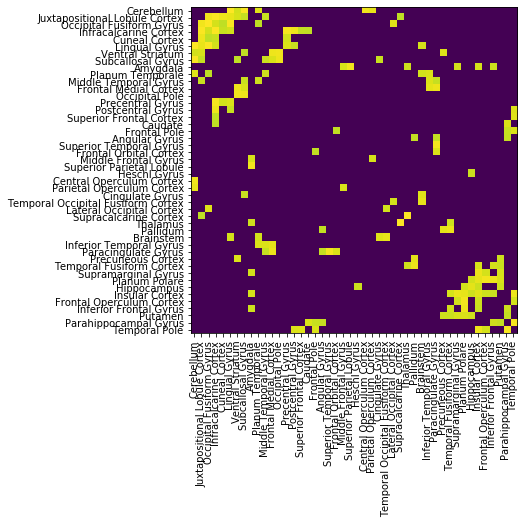

In [29]:
plt.figure(figsize=(6, 6));
plt.imshow(pval_corr.loc[reordered_cols,reordered_cols]);
plt.xticks(range(len(rois)),reordered_cols, rotation=90);
plt.yticks(range(len(rois)),reordered_cols);

In [73]:
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, leaves_list, fcluster, dendrogram

dist_matrix     = covs.loc[:,np.array(window_ys)=='Face']
linkage_matrix  = linkage(dist_matrix, method='average')
ordered_linkage = optimal_leaf_ordering(linkage_matrix, dist_matrix)
index           = leaves_list(ordered_linkage)
cols            = [dist_matrix.index[idx] for idx in index]

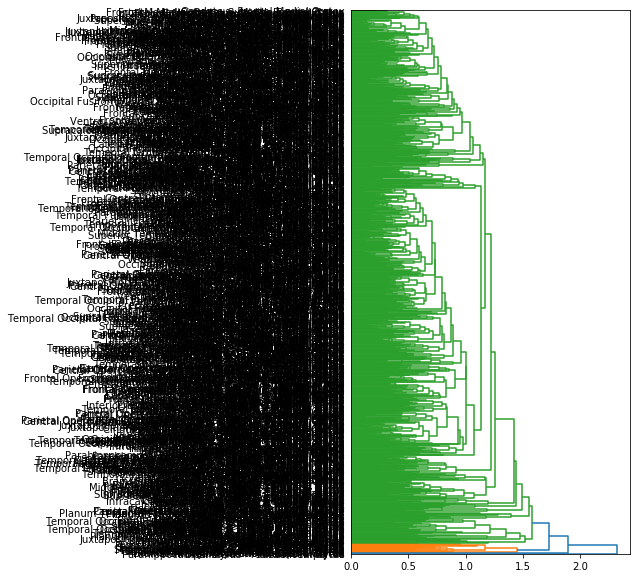

In [76]:
from scipy.cluster import hierarchy

plt.figure(figsize=(5, 10));
dn = hierarchy.dendrogram(linkage_matrix, labels=list(dist_matrix.index),\
        orientation='right', leaf_font_size=10);#, distance_sort=True);

[x.set_color("red") for x in plt.gca().get_yticklabels() if (x.get_text()=='Amygdala') or (x.get_text()=='Amygdala')];

In [40]:
def create_adjacency(edges):
    conns = []
    for edge, val in edges.iteritems():
        from_, to = edge.split(' > ')
        conns.append([from_, to, val])
    conns = pd.DataFrame(conns)
    conns.columns = ['from', 'to', 'val']
    nodes = set(list(conns['from'].values)+list(conns['to'].values))
    adj = pd.DataFrame(columns=nodes, index=nodes)
    for idx, conn in conns.iterrows():
        adj.loc[conn['from'], conn['to']] = conn['val']
    adj = adj.fillna(0)
    return adj

In [108]:
[col for col in time_series.columns if 'thal' in col]

[]

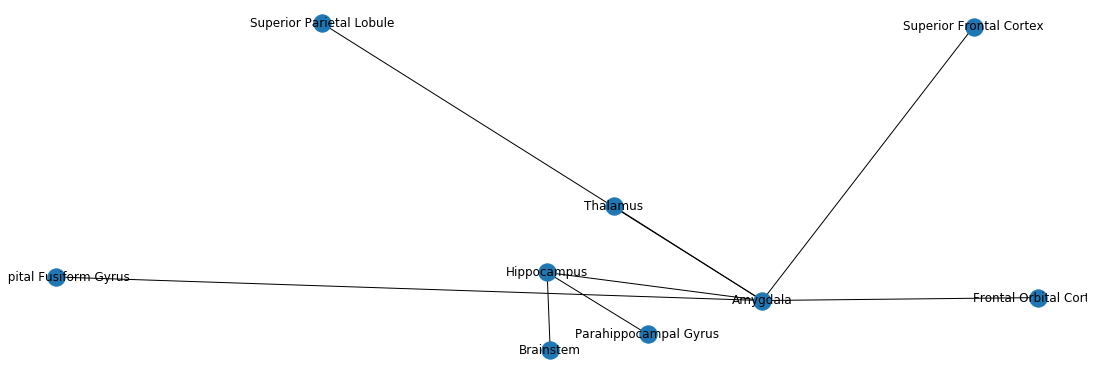

In [121]:
import networkx as nx

G = nx.Graph()
for e in edges.index:
    G.add_edge(*e.split(' > '))
    
plt.figure(figsize=(15, 5));
nx.draw(G, with_labels=True, pos=pos);
plt.grid();

In [42]:
adj = create_adjacency(sig_edges)
view_connectome(adj, coords, edge_cmap='Reds_r', symmetric_cmap=False)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
# modes_df = pd.DataFrame()
# modes_df['face'] = counts_face.apply(lambda x: x.idxmax(), axis=1)
# modes_df['shape'] = counts_shape.apply(lambda x: x.idxmax(), axis=1)

# modes_df = modes_df[(modes_df['face']!='x <> y') & (modes_df['shape']!='x <> y')]
# modes_df = modes_df[(modes_df['face']!='x <<>> y') & (modes_df['shape']!='x <<>> y')]
# modes_df[modes_df['face']!=modes_df['shape']]

In [ ]:
# def edge_labels(x):
#     nonzero = x[['x > y',  'x < y']]
#     direction = ttest_rel(x[['x > y', 'x >> y']].values, x[['x < y',  'x << y']].values)[1]>0.5
#     if   (direction==False) & (magnitude==False):
#         nature = 'excitatory' if sum(x[['x > y',  'x < y']].values)>sum(x[['x >> y', 'x << y']].values) else 'inhibitory'
#         arrow  = '>' if sum(x[['x > y',  'x >> y']].values)>sum(x[['x < y',  'x << y']].values) else '<'
#     elif (direction==False) & (magnitude==True):
#         nature = 'inhibitory'
#         arrow  = '>' if sum(x[['x > y',  'x >> y']].values)>sum(x[['x < y',  'x << y']].values) else '<'
#     elif (direction==True)  & (magnitude==False):
#         nature, arrow = '+ve feedback loop', None
#     elif (direction==True)  & (magnitude==True):
#         nature, arrow = '-ve feedback loop', None

#     return pd.Series({'nature':nature, 'label':arrow})

# def edge_labels(x):
#     magnitude = ttest_rel(x[['x > y',  'x < y']].values, x[['x >> y', 'x << y']].values)[1]>0.5
#     direction = ttest_rel(x[['x > y', 'x >> y']].values, x[['x < y',  'x << y']].values)[1]>0.5
#     if   (direction==False) & (magnitude==False):
#         nature = 'excitatory' if sum(x[['x > y',  'x < y']].values)>sum(x[['x >> y', 'x << y']].values) else 'inhibitory'
#         arrow  = '>' if sum(x[['x > y',  'x >> y']].values)>sum(x[['x < y',  'x << y']].values) else '<'
#     elif (direction==False) & (magnitude==True):
#         nature = 'inhibitory'
#         arrow  = '>' if sum(x[['x > y',  'x >> y']].values)>sum(x[['x < y',  'x << y']].values) else '<'
#     elif (direction==True)  & (magnitude==False):
#         nature, arrow = '+ve feedback loop', None
#     elif (direction==True)  & (magnitude==True):
#         nature, arrow = '-ve feedback loop', None

#     return pd.Series({'nature':nature, 'label':arrow})